# Anomaly Detection in Python

We will start off just by looking at the dataset from a _visual_ perspective and see if we can find the anomalies.

## Detecting anomalies just by seeing

In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Shpw the plots in your Jupyter Notebook
%matplotlib inline
# Use a predefined style set
plt.style.use('ggplot')

Let's first create a dummy dataset for ourselves. The dataset will contain just two columns - 
- Name of the employees of an organization
- Salaries of those employees (in USD) within a range of 1000 to 2500 (Monthly)

For generating the names (and make them look like the real ones) we will use a Python library called `Faker` (read the documentation [here](https://faker.readthedocs.io/en/latest/index.html)). For generating salaries, we will use the good old `numpy`. After generating these, we will merge them in a `pandas` DataFrame. We are going to generate records for 100 employees. Let's begin. 

**Note**: Creating dummy datasets for experimental purposes is indeed an essential skill.

In [ ]:
#install if needed, skip to next cell if already installed
!pip install faker

In [2]:
from faker import Faker
fake = Faker()

# To ensure the results are reproducible
#fake.seed(4321) TypeError: Calling `.seed()` on instances is deprecated. Use the class method `Faker.seed()` instead.
Faker.seed(4321)

names_list = []

fake = Faker()
for _ in range(100):
  names_list.append(fake.name())

# Verify if 100 names were generated
len(names_list)

100

In [3]:
# To ensure the results are reproducible
np.random.seed(7)

salaries = []
for _ in range(100):
    salary = np.random.randint(1000,2500)
    salaries.append(salary)

    # Verify if 100 salariy values were generated
len(salaries)

100

In [4]:
# Create pandas DataFrame
salary_df = pd.DataFrame(
    {'Person': names_list,
     'Salary (in USD)': salaries
    })

# Print a subsection of the DataFrame
salary_df.head()

,Person,Salary (in USD)
0,Jason Brown,1175
1,Jacob Stein,2220
2,Cody Brown,1537
3,Larry Morales,1502
4,Jessica Hendricks,1211


Let's now manually change the salary entries of two individuals. In reality, this can actually happen for a number of reasons such as the data recording software may have got corrupted at the time of recording the respective data.

In [5]:
salary_df.at[16, 'Salary (in USD)'] = 23
salary_df.at[65, 'Salary (in USD)'] = 17

In [6]:
# Verify if the salaries were changed
print(salary_df.loc[16])
print(salary_df.loc[65])

Person             Miss Amanda Harris MD
Salary (in USD)                       23
Name: 16, dtype: object
Person             Joyce Bishop
Salary (in USD)              17
Name: 65, dtype: object


### Boxplots are great! 

As mentioned in the earlier sections, the generation of anomalies within data directly depends on the generation of the data points itself. To simulate this, our approach is good enough to proceed. Let's now some basic statistics (like minimum value, maximum value, 1st quartile values etc.) in the form of a boxplot. 

Boxplot, because we get the following information all in just one place t


![](https://pro.arcgis.com/en/pro-app/help/analysis/geoprocessing/charts/GUID-0E2C3730-C535-40CD-8152-80D794A996A7-web.png)

Courtesy: [This blog](https://pro.arcgis.com/en/pro-app/help/analysis/geoprocessing/charts/box-plot.htm)

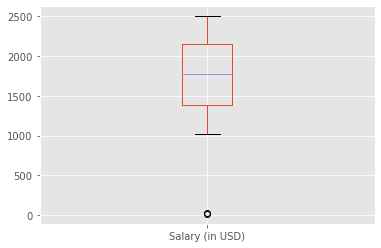

In [7]:
salary_df['Salary (in USD)'].plot(kind='box')
plt.show()

Notice the tiny circle point in the bottom. You instantly get a feeling of something wrong in there as _it deviates hugely from the rest of the data_. Now, you decide to look at the data from another visual perspective i.e. in terms of _histograms_. 

### How about histograms? 

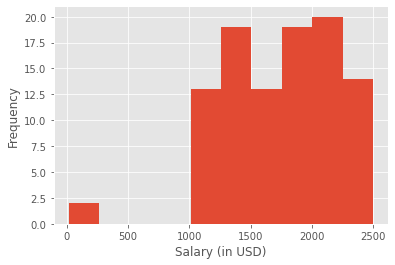

In [8]:
ax = salary_df['Salary (in USD)'].plot(kind='hist')
ax.set_xlabel('Salary (in USD)')
plt.show()

In the above histogram plot also, we can see there's one particular bin that is just not right _as it deviates hugely from the rest of the data_ (phrase repeated intentionally to put emphasis on the deviation part). We can also infer that there are only two employees for which the salaries seem to be distorted (look at the y-axis). 

So what might be an immediate way to confirm that the dataset contains anomalies? Let's take a look at the minimum and maximum values of the column `Salary (in USD)`.  

In [9]:
print('Minimum salary ' + str(salary_df['Salary (in USD)'].min()))
print('Maximum salary ' + str(salary_df['Salary (in USD)'].max()))

Minimum salary 17
Maximum salary 2498


Look at the **minimum value**. From the payroll department of this hypothetical organization, you know that the minimum salary of an employee there is $1000. But you found out something different. Hence, its worth enough to conclude that this is indeed an anomaly. Let's now try to look at the data from a different perspective other than just simply plotting it. 

**Note**: Although our dataset contains only one feature (i.e. `Salary (in USD)`) that contains an anomaly, but in reality, there can be many features which will have anomalies in them. Visualizations will help you. 

## Clustering based approach for anomaly detection

We have seen how clustering and anomaly detection are closely related but they serve different purposes. But clustering can be used for anomaly detection. In this approach, we start by grouping the similar kind of objects. Mathematically, this similarity is measured by distance measurement functions like Euclidean distance, Manhattan distance and so on. Euclidean distance is a very popular choice when choosing in between several distance measurement functions. Let's take a look at what Euclidean distance is all about. 

We are going to use [K-Means clustering](https://en.wikipedia.org/wiki/K-means_clustering) which will help us cluster the data points (salary values in our case). The implementation that we are going to be using for `KMeans` uses Euclidean distance internally. Let's get started. 

In [10]:
# Convert the salary values to a numpy array
salary_raw = salary_df['Salary (in USD)'].values

# For compatibility with the SciPy implementation
#salary_raw = pok.reshape(-1, 1) pok is an error
salary_raw = salary_raw.reshape(-1, 1)
salary_raw = salary_raw.astype('float64')

We will now import the `kmeans` module from `scipy.cluster.vq`. SciPy stands for Scientific Python and provides a variety of convenient utilities for performing scientific experiments. Follow its documentation [here](https://docs.scipy.org/doc/). We will then apply `KMeans` to `salary_raw`. 

In [11]:
from scipy.cluster.vq import kmeans 
from scipy.cluster.vq import vq #needed to add this line

# Supply the data and the number of clusters to kmeans()
codebook, distortion = kmeans(salary_raw, 4)

In the above chunk of code, we fed the salary data points the `kmeans()`. We also specified the number of clusters to which we want to group the data points. `cookbook` is the centroids generated by `kmeans()` and `distortion` is the averagedEuclidean distance between the data points fed and the centroids generated by `kmeans()`. 

Let's assign the groups of the data points by calling th `vq()` method. It takes - 
- The data points
- The centroid as generated by the clustering algorithm (`kmeans()` in our case)

It then returns the groups of the data points and the distance between the observation and its nearest group.

In [12]:
#groups, cdist = cluster.vq.vq(salary_raw, codebook) just needed vq here
groups, cdist = vq(salary_raw, codebook)

Let's now plot the groups we have got. 

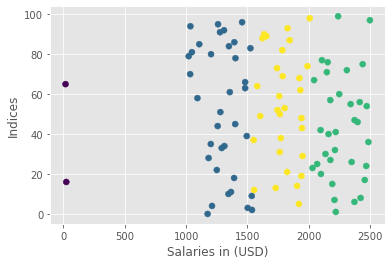

In [13]:
plt.scatter(salary_raw, np.arange(0,100), c=groups)
plt.xlabel('Salaries in (USD)')
plt.ylabel('Indices')
plt.show()

The above method for anomaly detection is purely [unsupervised](https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms/) in nature. If we had the class-labels of the data points, we could have easily converted this to a [supervised learning](https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms/) problem, specifically a _classification_ problem. 

# Real world example

There was a lawsuit involving the amount of time children were detained by ICE.  We were asked to analyze the existing data to see if this was a standard practice.

In [14]:
#Read in Data
#https://data.world/government/us-customs-and-border-protection-child-detentions-2017-20/discuss/us-customs-and-border-protection-child-detentions-2017-20/li3kopgi
import pandas as pd
df2=pd.read_csv('cbp.csv')

C:\Users\Mark Cichonski\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (2,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
df2.head()

,date_in,date_out,app_date,hours_in_custody,age_group,gender,citizenship,border,sector,field_office,source
0,2017-01-20 00:10:00,2017-01-20 10:08:00,NaN,9.950000,6-8 years,Female,EL SALVADOR,SBO,(b)(7)(E ),NaN,BP
1,2017-01-20 00:15:00,2017-01-24 17:30:00,NaN,113.233333,3-5 years,Female,GUATEMALA,SBO,(b)(7)(E ),NaN,BP
2,2017-01-20 00:22:00,2017-01-24 17:47:00,NaN,113.416667,3-5 years,Female,BRAZIL,SBO,(b)(7)(E ),NaN,BP
3,2017-01-20 00:30:00,2017-01-21 06:35:00,NaN,30.083333,12-14 years,Male,EL SALVADOR,SBO,(b)(7)(E ),NaN,BP
4,2017-01-20 00:30:00,2017-01-21 13:03:00,NaN,36.533333,3-5 years,Male,HONDURAS,SBO,(b)(7)(E ),NaN,BP


In [16]:
df2.shape

(583808, 11)

In [17]:
df2.describe()

,hours_in_custody
count,583093.000000
mean,65.019625
std,81.249861
min,-13.820000
25%,31.016667
50%,53.083333
75%,85.900000
max,27576.080000


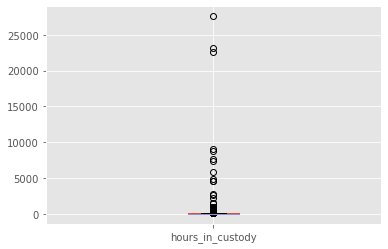

In [18]:
df2['hours_in_custody'].plot(kind='box')
plt.show()

Initial plot shows many outliers with the 50th percentile and maximum and minimum with low variation compared to the high valued outliers.  Let's investigate further. 

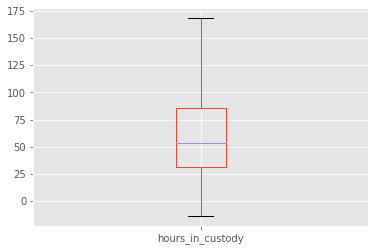

In [19]:
#let's remove the outliers
df2['hours_in_custody'].plot(kind='box', showfliers=False)
plt.show()

Clearly the maximum being around 170 hours compared to the outliers over 25000, let's take a closer look.

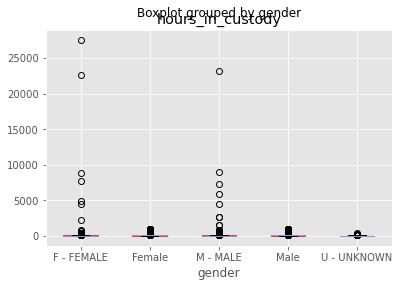

In [20]:
df2.boxplot(column='hours_in_custody',by='gender')
plt.show()

Interesting that there are two types of codings for gender, and the outliers are in the gender "-" categories.

<AxesSubplot:title={'center':'hours_in_custody'}, xlabel='gender'>

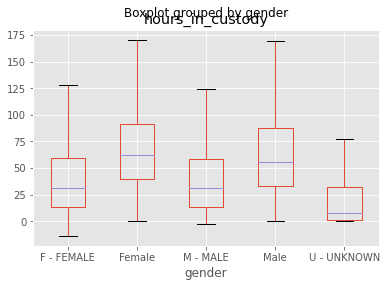

In [21]:
#Let's look at with the removed outliers
df2.boxplot(column='hours_in_custody',by='gender', showfliers=False)

<AxesSubplot:title={'center':'hours_in_custody'}, xlabel='citizenship'>

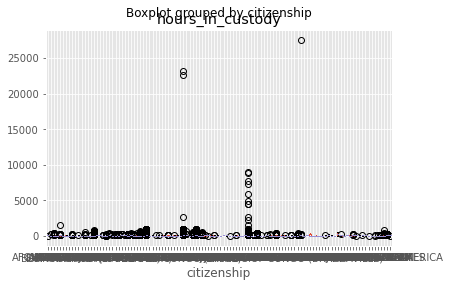

In [22]:
#Let's look at quickly by country of origin
df2.boxplot(column='hours_in_custody',by='citizenship')

Besides the large number of countries of origin, it seems most of the variation is coming from 4 different countries.  Let's see if we can lock down on those

In [23]:
#Let's create a new dataframe with values over 500 hours
df3=df2.loc[df2['hours_in_custody'] >= 500]

In [24]:
df3.head()

,date_in,date_out,app_date,hours_in_custody,age_group,gender,citizenship,border,sector,field_office,source
8807,2017-03-29 21:39:00,2017-05-01 12:38:00,NaN,782.966667,1-2 years,Male,GUATEMALA,SBO,(b)(7)(E ),NaN,BP
28146,2017-09-12 23:05:00,2017-10-18 16:23:00,NaN,857.300000,15-18 years,Male,MEXICO,SBO,(b)(7)(E ),NaN,BP
32645,2017-10-10 15:10:00,2017-11-04 12:30:00,NaN,589.500000,15-18 years,Female,MEXICO,SBO,(b)(7)(E ),NaN,BP
41928,2017-11-21 17:15:00,2017-12-12 15:42:00,NaN,502.433333,6-8 years,Female,EL SALVADOR,SBO,(b)(7)(E ),NaN,BP
83685,2018-05-01 01:55:00,2018-06-03 13:43:00,NaN,803.783333,9-11 years,Female,GUATEMALA,SBO,(b)(7)(E ),NaN,BP


There are two different sources for these child detentions: CBP Office of Field Operations (OFO) and CBP Border Patrol (BP). Let's take a look at those.

In [25]:
source=df3.source.value_counts()
source

BP     692
OFO     28
Name: source, dtype: int64

<AxesSubplot:title={'center':'hours_in_custody'}, xlabel='source'>

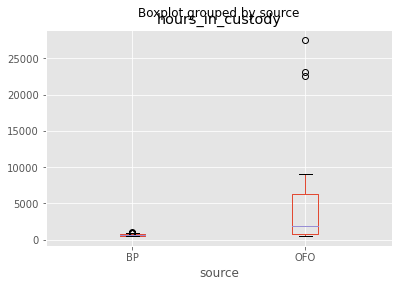

In [26]:
df3.boxplot(column='hours_in_custody',by='source')

<AxesSubplot:title={'center':'hours_in_custody'}, xlabel='source'>

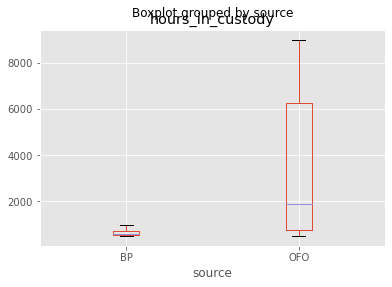

In [27]:
#without the outliers
df3.boxplot(column='hours_in_custody',by='source', showfliers=False)

Interesing that there is so much more variation in the OFO, let's focus on that.

In [28]:
#Let's create a data frame with just the OFO data
df4=df2.loc[df2['source'] == 'OFO']
df4.head()

,date_in,date_out,app_date,hours_in_custody,age_group,gender,citizenship,border,sector,field_office,source
488818,2017-01-17 14:04:00,2017-01-21 11:29:00,2017-01-20 09:32:31,93.42,3-5 years,M - MALE,GUATEMALA,NaN,NaN,EL PASO,OFO
488819,2017-01-17 17:33:00,2017-01-21 08:20:00,2017-01-20 08:39:48,86.78,6-8 years,M - MALE,GUATEMALA,NaN,NaN,EL PASO,OFO
488820,2017-01-17 17:41:00,2017-01-21 08:20:00,2017-01-20 08:41:02,86.65,6-8 years,F - FEMALE,GUATEMALA,NaN,NaN,EL PASO,OFO
488821,2017-01-17 17:44:00,2017-01-21 08:20:00,2017-01-20 08:50:42,86.60,1-2 years,M - MALE,GUATEMALA,NaN,NaN,EL PASO,OFO
488822,2017-01-17 19:13:00,2017-01-24 11:30:00,2017-01-20 14:28:00,160.28,9-11 years,M - MALE,MEXICO,NaN,NaN,EL PASO,OFO


In [29]:
df4.shape

(94990, 11)

In [30]:
# Convert the hours in custody values to a numpy array
hours_raw = df4['hours_in_custody'].values

# For compatibility with the SciPy implementation
hours_raw = hours_raw.reshape(-1, 1)
hours_raw = hours_raw.astype('float64')

In [32]:
#Check for any inf or NaN values
np.isnan(hours_raw).any()

True

In [33]:
#remove NaN
hours_raw = hours_raw[~np.isnan(hours_raw)]

In [34]:
#Check for any inf or NaN values
np.isnan(hours_raw).any()

False

In [38]:
from scipy.cluster.vq import kmeans 
from scipy.cluster.vq import vq #needed to add this line

# Supply the data and the number of clusters (let's start with 4) to kmeans()
codebook, distortion = kmeans(hours_raw, 8)

In [39]:
#groups, cdist = cluster.vq.vq(salary_raw, codebook) just needed vq here
groups, cdist = vq(hours_raw, codebook)

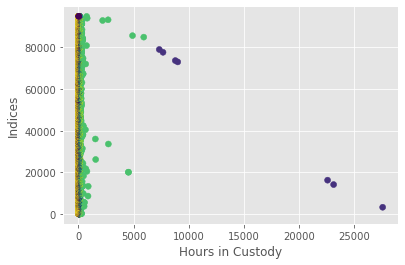

In [40]:
plt.scatter(hours_raw, np.arange(0,94987), c=groups)
plt.xlabel('Hours in Custody')
plt.ylabel('Indices')
plt.show()